In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np
from natsort import natsorted

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return natsorted(list(allsubs))

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['wrat'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest', 'nback', 'emoid'], subs)
print(X[0].shape)

830
(830, 264, 124)


In [3]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 3

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [0.01, 0.15], 1/tr)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

p = [np.stack([ts_to_flat_fc(ts) for ts in filter_design_ts(Xp)]) for Xp in X]
# Xfiltnorm = [tsmod/np.linalg.norm(tsmod, axis=(-1), keepdims=True) for tsmod in ts]
print(p[0].shape)

(830, 34716)


In [4]:
# Get all partial correlations

from nilearn.connectome import ConnectivityMeasure

cm = ConnectivityMeasure(kind='partial correlation')

a,b = np.triu_indices(264, 1)

allp = []
for taskidx in range(3):
    Xf = filter_design_ts(X[taskidx])
    partials = cm.fit_transform(Xf.transpose(0,2,1))
    partials = partials[:,a,b]
    allp.append(partials)
    print('Done partials')

allp = np.stack(allp)
print(allp.shape)

Done partials
Done partials
Done partials
(3, 830, 34716)


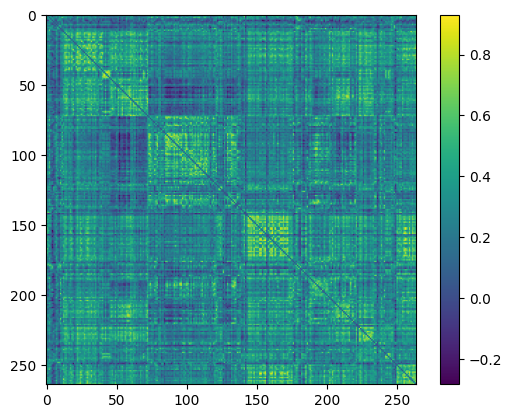

In [5]:
import matplotlib.pyplot as plt

def vec2mat(vec):
    a,b = np.triu_indices(264,1)
    mat = np.zeros((264,264))
    mat[a,b] = vec
    mat = mat + mat.T
    return mat

plt.imshow(vec2mat(p[0][0]))
plt.colorbar()
plt.show()

In [186]:
import torch
import torch.nn as nn
import torch.nn.functional as F

ntrain = 500
task = 'wrat'
mse = nn.MSELoss()

class LatSim(nn.Module):
    def __init__(self, d, ld=2, l1=0, stop=0):
        super(LatSim, self).__init__()
        self.A = nn.Parameter((torch.randn(d,ld)/(d**0.5)).float().cuda())
        self.d = d
        self.l1_ = l1
        self.stop = stop

    def E(self, xtr, xt=None):
        AT = (xtr@self.A).T
        if xt is not None:
            A = xt@self.A
        else:
            A = AT.T
        E = A@AT
        return F.softmax(E,dim=1)

    def l1(self):
        return self.l1_*torch.mean(torch.abs(self.A)*self.d**0.5)

    def forward(self, xtr, xt, ytr):
        E = self.E(xtr, xt)
        return E@ytr
    
def train(latsim, xtr, ytr, nepochs=1000, pperiod=200):
    # Optimizers
    optim = torch.optim.Adam(latsim.parameters(), lr=1e-4, weight_decay=0)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=20, factor=0.75, eps=1e-7)

    for epoch in range(nepochs):
        optim.zero_grad()
        yhat = latsim(xtr, xtr, ytr)
        loss = mse(yhat, ytr)**0.5
        (latsim.l1()+loss).backward()
        optim.step()
        if loss < latsim.stop:
            break
        sched.step(loss)
        if epoch % pperiod == 0 or epoch == nepochs-1:
            print(f'{epoch} recon: {[float(ls) for ls in [loss]]} lr: {sched._last_lr}')

    optim.zero_grad()
    print('Complete')
    
rmse1 = []
rmse2 = []

for i in range(20):
    idcs = np.random.permutation(830)
    yhat1 = []
    yhat2 = []
    
    for j in range(1,3):
        x = p[j]
        x = x[idcs]
        xtr = x[:ntrain]
        xt = x[ntrain:]

        mux = np.mean(xtr, axis=0, keepdims=True)
        sigx = np.std(xtr, axis=0, keepdims=True)
        xtr = xtr - mux
        xt = xt - mux

        y = get_y(metadict, [task], subs)[0]
        y = y[idcs]
        ytr = y[:ntrain]
        yt = y[ntrain:]

        mu = np.mean(ytr)
        ytr = ytr - mu
        yt = yt - mu

        xxtr = torch.from_numpy(xtr).float().cuda()
        xxt = torch.from_numpy(xt).float().cuda()

        yytr = torch.from_numpy(ytr).float().cuda()
        yyt = torch.from_numpy(yt).float().cuda()

    #     print([z.shape for z in [xxtr, xxt, yytr, yyt]])

        # Least squares

        w,_,_,_ = torch.linalg.lstsq(xxtr, yytr)

        yhat = xxt@w
        yhat1.append(yhat)

#     rmse = mse(yhat, yyt)**0.5
#     rmse = float(rmse)
#     print(rmse)
#     rmse1.append(rmse)

    # LatSim

        latsim = LatSim(xxtr.shape[-1], 2, stop=10, l1=0)
        train(latsim, xxtr, yytr)

        yhat = latsim(xxtr, xxt, yytr)
        yhat2.append(yhat)
#         yhat2.append(torch.zeros(yyt.shape[0]).float().cuda())
#         rmse = mse(yhat, yyt)**0.5
#         rmse = float(rmse)
#         print(rmse)
#     rmse2.append(rmse)
    yhat1 = sum(yhat1)/2
    yhat2 = sum(yhat2)/2
    rmsea = float(mse(yhat1, yyt)**0.5)
    rmseb = float(mse(yhat2, yyt)**0.5)
    print(rmsea)
    print(rmseb)
    rmse1.append(rmsea)
    rmse2.append(rmseb)
    print('---')
    
print('....')
for rmse in [rmse1, rmse2]:
    a = np.array(rmse)
    print(np.mean(a), np.std(a))

0 recon: [15.616283416748047] lr: [0.0001]
Complete
0 recon: [15.617281913757324] lr: [0.0001]
Complete
15.026070594787598
14.956414222717285
---
0 recon: [15.776405334472656] lr: [0.0001]
Complete
0 recon: [15.779888153076172] lr: [0.0001]
Complete
15.075579643249512
14.981001853942871
---
0 recon: [15.759766578674316] lr: [0.0001]
Complete
0 recon: [15.759507179260254] lr: [0.0001]
Complete
14.499899864196777
14.497820854187012
---
0 recon: [16.096582412719727] lr: [0.0001]
Complete
0 recon: [16.092714309692383] lr: [0.0001]
Complete
14.479837417602539
14.471817016601562
---
0 recon: [16.168251037597656] lr: [0.0001]
Complete
0 recon: [16.156492233276367] lr: [0.0001]
Complete
14.81769847869873
14.506149291992188
---
0 recon: [15.685562133789062] lr: [0.0001]
Complete
0 recon: [15.685370445251465] lr: [0.0001]
Complete
15.195327758789062
14.86137866973877
---
0 recon: [15.477575302124023] lr: [0.0001]
Complete
0 recon: [15.481966972351074] lr: [0.0001]
Complete
15.122054100036621
15.

In [6]:
# Load top lstsq weights

basedirfc = '../../Work/ImageNomer/fc-age'
basedirpc = '../../Work/ImageNomer/pc-age'

paras = ['rest', 'nback', 'emoid']
wpc = dict(rest=[], nback=[], emoid=[])
wfc = dict(rest=[], nback=[], emoid=[])

for base,dct in [(basedirfc, wfc), (basedirpc, wpc)]:
    for para in paras:
        for i in range(20):
            fname = f'{base}/lstsq-{para}{i}.pkl'
            with open(fname, 'rb') as f:
                wdct = pickle.load(f)
                dct[para].append(wdct['w'])
        dct[para] = np.stack(dct[para])
    
print('Done')

Done


In [7]:
# Load "training set" subject features
# Multiply with weights

fcfeat = dict(rest=[], nback=[], emoid=[])
pcfeat = dict(rest=[], nback=[], emoid=[])

wfeatfc = dict()
wfeatpc = dict()

for ptrain,para in zip(p, ['rest', 'nback', 'emoid']):
    fcfeat[para] = np.mean(ptrain[:500], axis=0)
    wfeatfc[para] = np.mean(wfc[para], axis=0)*fcfeat[para]
    
for allptrain,para in zip(allp, ['rest', 'nback', 'emoid']):
    pcfeat[para] = np.mean(allptrain[:500], axis=0)
    wfeatpc[para] = np.mean(wpc[para], axis=0)*pcfeat[para]
    
print(wfeatfc['rest'].shape)
print('Done')

(34716,)
Done


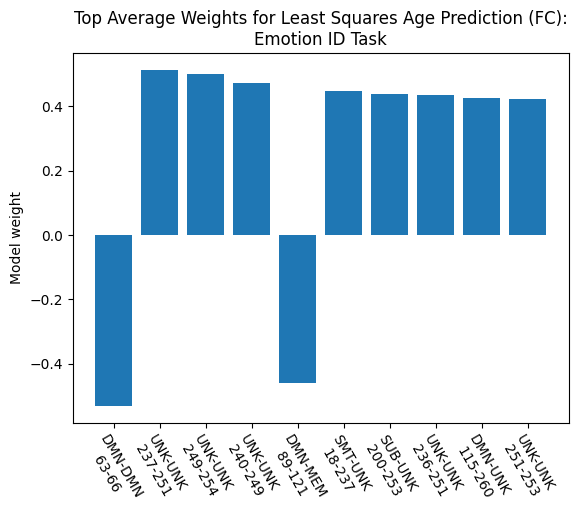

In [12]:
import matplotlib.pyplot as plt

ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45, 
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85, 
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132, 
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186, 
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257, 
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,  
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248, 
249, 252, 253]

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

def label(idcs, labtype='raw'):
    if labtype == 'raw':
        return [str(idx) for idx in idcs]
    if labtype == 'rois':
        return [f'{rois_a[idx]}-{rois_b[idx]}' for idx in idcs]
    if labtype == 'fns':
        fns = []
        for idx in idcs:
            a, b = rois_a[idx], rois_b[idx]
            fns.append(f'{fn_names_map[a]}-{fn_names_map[b]}')
        return fns

def d_from_vec(fc):
    n = fc.size
    return int(round((1+(1+8*n)**0.5)/2))

def make_fn_map(bounds):
    fnidx = 0
    bmap = dict()
    for i in range(264):
        if i >= bounds[fnidx]:
            fnidx += 1
        bmap[i] = fnidx
    return bmap

bounds = [30, 35, 49, 62, 120, 125, 156, 181, 199, 212, 221, 232, 236, 264]
fn_map = make_fn_map(bounds)

fn_names = 'SMT,SMH,CNG,AUD,DMN,MEM,VIS,FRNT,SAL,SUB,VATN,DATN,CB,UNK'.split(',')
fn_names_map = {idx: fn_names[fn] for idx,fn in fn_map.items()}

rois_a, rois_b = np.triu_indices(264,1)


def vec2mat(fc, fillones=True):
    d = d_from_vec(fc)
    a,b = np.triu_indices(d,1)
    mat = np.zeros((d,d))
    mat[a,b] = fc
    mat += mat.T
    ones = np.arange(d)
    if fillones:
        mat[ones,ones] = 1
    return mat

def mat2vec(fc):
    d = fc.shape[0]
    a,b = np.triu_indices(d,1)
    return fc[a,b]

def bar_private(data, labels):
    fig, ax = plt.subplots()
    x = np.arange(len(data))
    ax.bar(x, height=data, tick_label=labels)
    ax.tick_params(axis='x', labelrotation=-60)
    return tobase64(fig)

# NOT REMAPPED
# wfeat = wfeatpc['nback']
wfeat = np.mean(wfc['emoid'], axis=0)
wfeat = mat2vec(remap(vec2mat(wfeat, False)))
fidcs = np.argsort(np.abs(wfeat))
labs1 = label(fidcs[:-11:-1], 'fns')
labs2 = label(fidcs[:-11:-1], 'rois')
labs = [f"{aa}\n{bb}" for aa,bb in zip(labs1,labs2)]

fig, ax = plt.subplots()
ax.bar(np.arange(10), height=wfeat[fidcs[:-11:-1]], tick_label=labs)
ax.tick_params(axis='x', labelrotation=-60)
ax.set_ylabel('Model weight')
ax.set_title("Top Average Weights for Least Squares Age Prediction (FC):\nEmotion ID Task")
# ax.set_ylabel('Product of mean PC and model weight')
# ax.set_title("Top Average Product of PC and\nLeast Squares Weights for Age Prediction (PC):\nnback Task")
fig.show()
fig.savefig('../../Work/ImageNomer/FiguresOHBM/top-emoid-fc.pdf')

In [156]:
import torch
import torch.nn as nn
import torch.nn.functional as F

mse = nn.MSELoss()
ntrain = 200
task = 'age'
stop = 20*20
maxiter = 3000

rmse_lstsq = []
rmse_mlp = []
rmse_latsim = []

for i in range(20):
    
    x = p[2][500:,fidcs[:-301:-1]]

    idcs = np.random.permutation(330)
    x = x[idcs]
    xtr = x[:ntrain]
    xt = x[ntrain:]

    mux = np.mean(xtr, axis=0, keepdims=True)
    sigx = np.std(xtr, axis=0, keepdims=True)
    xtr = xtr - mux
    xt = xt - mux

    y = get_y(metadict, [task], subs)[0]
    y = y[500:]
    y = y[idcs]
    ytr = y[:ntrain]
    yt = y[ntrain:]

    mu = np.mean(ytr)
    ytr = ytr - mu
    yt = yt - mu

    xxtr = torch.from_numpy(xtr).float().cuda()
    xxt = torch.from_numpy(xt).float().cuda()

    yytr = torch.from_numpy(ytr).float().cuda()
    yyt = torch.from_numpy(yt).float().cuda()

    print([z.shape for z in [xxtr, xxt, yytr, yyt]])

    # Least squares

    w,_,_,_ = torch.linalg.lstsq(xxtr, yytr)

    yhat = xxt@w

    rmse = mse(yhat, yyt)**0.5
    rmse = float(rmse)
    print(rmse)
    rmse_lstsq.append(rmse)

    # MLP

    class MLP(nn.Module):
        def __init__(self, d):
            super(MLP, self).__init__()
            self.fc1 = nn.Linear(d,40).float().cuda()
            self.fc2 = nn.Linear(40,1).float().cuda()

        def l1(self):
            return torch.mean(torch.abs(self.fc1.weight))

        def forward(self, x):
            x = F.relu(self.fc1(x))
            return self.fc2(x).squeeze()

    nepochs = maxiter
    pperiod = 500

    mlp = MLP(xxtr.shape[1])

    # Optimizers
    optim = torch.optim.Adam(mlp.parameters(), lr=1e-4, weight_decay=0)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=20, factor=0.75, eps=1e-7)

    for epoch in range(nepochs):
        optim.zero_grad()
        yhat = mlp(xxtr)
        loss = mse(yhat, yytr)
        loss.backward()
        optim.step()
        if loss < stop:
            break
        sched.step(loss)
        if epoch % pperiod == 0 or epoch == nepochs-1:
            print(f'{epoch} recon: {[float(ls)**0.5 for ls in [loss]]} '
                 f'lr: {sched._last_lr}')

    print('Complete')

    yhat = mlp(xxt)
    rmse = mse(yhat, yyt)**0.5
    rmse = float(rmse)
    print(rmse)
    rmse_mlp.append(rmse)

    # LatSim

    class LatSim(nn.Module):
        def __init__(self, d, ld=2):
            super(LatSim, self).__init__()
            self.A = nn.Parameter((torch.randn(d,ld)/(d**0.5)).float().cuda())

        def E(self, xtr, xt=None):
            AT = (xtr@self.A).T
            if xt is not None:
                A = xt@self.A
            else:
                A = AT.T
            E = A@AT
            return F.softmax(E,dim=1)

        def l1(self):
            return torch.mean(torch.abs(self.A))

        def forward(self, xtr, xt, ytr):
            E = self.E(xtr, xt)
            return E@ytr

    latsim = LatSim(xxtr.shape[1], ld=2)

    nepochs = maxiter
    pperiod = 500

    # Optimizers
    optim = torch.optim.Adam(latsim.parameters(), lr=1e-4, weight_decay=0)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=20, factor=0.75, eps=1e-7)

    for epoch in range(nepochs):
        optim.zero_grad()
        yhat = latsim(xxtr, xxtr, yytr)
        loss = mse(yhat, yytr)
        loss.backward()
        optim.step()
        if loss < stop:
            break
        sched.step(loss)
        if epoch % pperiod == 0 or epoch == nepochs-1:
            print(f'{epoch} recon: {[float(ls)**0.5 for ls in [loss]]} lr: {sched._last_lr}')

    print('Complete')

    yhat = latsim(xxtr, xxt, yytr)
    rmse = mse(yhat, yyt)**0.5
    rmse = float(rmse)
    print(rmse)
    rmse_latsim.append(rmse)
    
    print(f'Finished {i}-----------')

[torch.Size([200, 300]), torch.Size([130, 300]), torch.Size([200]), torch.Size([130])]
40.781394958496094
0 recon: [37.37963593478657] lr: [0.0001]
500 recon: [35.53539134561399] lr: [0.0001]
1000 recon: [32.76031005712648] lr: [0.0001]
1500 recon: [29.74860795554926] lr: [0.0001]
2000 recon: [26.777089315439632] lr: [0.0001]
2500 recon: [24.025565200492682] lr: [0.0001]
2999 recon: [21.552781720751124] lr: [0.0001]
Complete
27.20387840270996
0 recon: [37.32898668689404] lr: [0.0001]
500 recon: [27.130134342703226] lr: [0.0001]
1000 recon: [21.52135028445953] lr: [0.0001]
Complete
26.02570343017578
Finished 0-----------
[torch.Size([200, 300]), torch.Size([130, 300]), torch.Size([200]), torch.Size([130])]
41.04852294921875
0 recon: [38.32230897576991] lr: [0.0001]
500 recon: [36.396907331272665] lr: [0.0001]
1000 recon: [33.39058661380573] lr: [0.0001]
1500 recon: [30.27892692166193] lr: [0.0001]
2000 recon: [27.291249822874203] lr: [0.0001]
2500 recon: [24.27190487396771] lr: [0.0001]

KeyboardInterrupt: 

In [152]:
for rmse in [rmse_lstsq, rmse_mlp, rmse_latsim]:
    rmse = np.array(rmse)
    print(np.mean(rmse), np.std(rmse))

45.55984020233154 2.9486670505259944
32.43394451141357 1.353473669380758
30.171114349365233 1.7210349583327367
